# Sentiment Analyisis aplicado a Noticias sobre Vacunas Covid-19

In [ ]:
!pip install sentileak #Instalar libreria para el analisis de sentimientos

In [1]:
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib.pylab as plt


from gensim.utils import tokenize # Tokenizacion, saca simbolos y números 
from gensim.matutils import corpus2csc # Llevar las listas de palabras a una descripción frecuentista
from gensim.corpora import Dictionary # Armado de base de palabras
from gensim.models import TfidfModel # Modelo tf-idf, para procesar y usar en nubes de palabras

import nltk # Dtopwords
nltk.download('stopwords')

from sentileak import dataloader
from sentileak import SentiLeak # Lexicon Based Method


from wordcloud import WordCloud #Para hacer nubes de palabras


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\julia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Exploracion inicial

In [34]:
df = pd.read_csv('texto_diarios.csv')


Este es un conjunto de textos con noticias scrapeado y ya algo procesado. Tiene por columnas por vacunas donde si aparece el nombre en el titulo se setea en 1 la columna. Tambien presenta el mes de la Noticia. Estas noticias corresponden al periodo Dic 2020 - Jun 2021, donde se reportaba los primeros estudios y prototipos de vacunas, hasta las primeras implementaciones

In [35]:
df.columns  

Index(['Unnamed: 0', 'titulo', 'Categorias', 'Links', 'Diario', 'Texto',
       'Sputnik', 'Pfizer', 'Astrazeneca', 'Sinopharm', 'Sinovac', 'Johnson',
       'mes'],
      dtype='object')

In [108]:
# Una de Ejemplo
df.iloc[0,:]

Unnamed: 0                                                             0
titulo                 El Gobierno confirmó la llegada de 1 millón de...
Categorias                                                    Nacionales
Links                  https://www.pagina12.com.ar/337284-el-gobierno...
Diario                                                         Página 12
Texto                  El Gobierno se prepara para traer este fin de ...
Sputnik                                                                0
Pfizer                                                                 0
Astrazeneca                                                            0
Sinopharm                                                              1
Sinovac                                                                0
Johnson                                                                0
mes                                                                  Abr
lexicon_sentimiento                                

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5374 entries, 0 to 5373
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   5374 non-null   int64 
 1   titulo       5374 non-null   object
 2   Categorias   1474 non-null   object
 3   Links        5374 non-null   object
 4   Diario       5374 non-null   object
 5   Texto        5369 non-null   object
 6   Sputnik      5374 non-null   int64 
 7   Pfizer       5374 non-null   int64 
 8   Astrazeneca  5374 non-null   int64 
 9   Sinopharm    5374 non-null   int64 
 10  Sinovac      5374 non-null   int64 
 11  Johnson      5374 non-null   int64 
 12  mes          5374 non-null   object
dtypes: int64(7), object(6)
memory usage: 545.9+ KB


La mayoria son columnas de Texto salvo las Dummy de las vacunas. Hay un par de Nulas en 'Texto' por lo que las sacamos

In [37]:
df = df[df['Texto'].notna()]

In [40]:
df.Diario.value_counts()

Infobae      2152
Clarín       1376
LaNacion     1253
Página 12     588
Name: Diario, dtype: int64

In [41]:
df.mes.value_counts()

Ene    1154
Dic    1076
Abr     904
Feb     849
May     645
Mar     379
Jun     362
Name: mes, dtype: int64

Hay Bastante variedad por diario y por mes, aunque la muestra no es equilibrada

In [44]:
df.groupby(['Diario','mes']).size() # Para ver cuanto hay por mes y por diario

Diario     mes
Clarín     Abr    272
           Dic    258
           Ene    203
           Feb    181
           Jun    117
           Mar    107
           May    238
Infobae    Abr    205
           Dic    488
           Ene    560
           Feb    399
           Jun    147
           Mar    175
           May    178
LaNacion   Abr    311
           Dic    219
           Ene    266
           Feb    180
           Jun     46
           Mar     45
           May    186
Página 12  Abr    116
           Dic    111
           Ene    125
           Feb     89
           Jun     52
           Mar     52
           May     43
dtype: int64

## Analisis de Sentimiento

In [45]:
textos = df['Texto']
sentimental = SentiLeak() # Inicializa el motor de analisis
df['lexicon_sentimiento'] = textos.apply(lambda x: sum([s['score'] for s in sentimental.compute_sentiment(x)['per_sentence_sentiment']])) # Lo aplica a cada texto

Para no tener que repetir el computo del analisis de sentimiento cargar el siguiente dataset. Es el mismo que antes pero ya corrido

In [47]:
df.read_csv('texto_diarios_analizado.csv') 

Podemos notar como varia el score, en terminos absolutos, en funcion del diario y en funcion del mes

In [46]:
df.groupby(['Diario']).lexicon_sentimiento.describe()

,count,mean,std,min,25%,50%,75%,max
Diario,,,,,,,,
Clarín,1376.0,10.258721,13.392424,-50.0,2.0,10.0,19.0,87.0
Infobae,2152.0,5.199814,13.624097,-64.0,-2.0,5.0,12.0,107.0
LaNacion,1253.0,3.791700,11.398063,-60.0,-2.0,3.0,9.0,72.0
Página 12,588.0,4.777211,13.188827,-48.0,-2.0,4.0,11.0,144.0


In [48]:
df.groupby(['mes']).lexicon_sentimiento.describe()

,count,mean,std,min,25%,50%,75%,max
mes,,,,,,,,
Abr,904.0,4.738938,13.225633,-60.0,-2.0,4.0,11.0,104.0
Dic,1076.0,7.884758,13.596364,-61.0,0.0,7.0,15.0,89.0
Ene,1154.0,4.865685,12.835478,-41.0,-3.0,4.0,11.0,107.0
Feb,849.0,6.053004,12.958598,-37.0,-2.0,5.0,12.0,144.0
Jun,362.0,7.375691,13.187011,-62.0,1.0,7.0,14.0,54.0
Mar,379.0,5.918206,12.467573,-50.0,-1.0,6.0,12.0,94.0
May,645.0,6.869767,13.958182,-64.0,-1.0,6.0,14.0,75.0


Veamos un grafico de las palabras mas negativas y positivas por mes. Primer procesamos los textos para que se saque la frecuencia de las palabras y se las ordene por el score de sentimiento de las oraciones en las que estan

In [56]:
def pre_procesaTexto(df, col_texto, tfidf = False, col_nombre = 'titulo', tipo_matriz = 'df'):
    """
    Esta función preprocesa los textos de un data frame.

    Es necesario pasarle:
        - df: pd.DataFrame()
          el data frame de nuestros datos
        - col_texto: str
          el nombre de la columna que contiene los textos
        - tfidf: Boolean (default = False)
          indica si queremos que nos devuelva la descripción tfidf o tf
        - col_nombre: str (default = 'titulo')
          indica cómo se quiere renombrar la matriz de textos en el espacio de términos
        - tipo_matris: str (default = 'df') puede ser df o scp
          si es df, devuelve un pandas dataframe
          si es scp, devuelve una matriz esparsa de scipy 
    Devuelve:
        - base_palabras: Dictionary de gensim
        - d_textos_terminos: pd.DataFrame
          data frame de palabras en el espacio de términos 
    """
    df[col_texto + '_proc'] = df[col_texto].apply(lambda letra: list(tokenize(letra.lower())
                                                                )
                                                 ) # Línea para tokenizar (además, nos saca signos de puntuación y números!)
    
    es_stop = nltk.corpus.stopwords.words('spanish')
    df[col_texto + '_proc'] = df[col_texto + '_proc'].apply(lambda letra: list(filter(lambda palabra: palabra not in es_stop,
                                                                                      letra)
                                                                          )
                                                           ) # Línea para filtrar las stopwords
    base_palabras = Dictionary(df[col_texto + '_proc'].to_list()) # Construcción de la base entero - palabra
    df[col_texto + '_proc'] = df[col_texto + '_proc'].apply(lambda letra : base_palabras.doc2bow(letra)) # Descripción de los textos en función de la frecuencia de las palabras
    if tfidf:
        tf_idf = TfidfModel(df[col_texto + '_proc'].to_list(),
                            normalize = True) # De ser requerido, se entrena el modelo TF-IDF. Esto va a ser usado en plotWC
        df[col_texto + '_proc'] = df[col_texto + '_proc'].apply(lambda letra: tf_idf[letra]) 
    if tipo_matriz == 'df':
        d_textos_terminos = pd.DataFrame(corpus2csc(df[col_texto + '_proc']).T.todense(),
                                         columns = list(base_palabras.values()),
                                         index = df[col_nombre].to_list()
                                         ) # Armamos la matriz (en formato pandas) de textos en el espacio de términos
    elif tipo_matriz == 'scp':
        d_textos_terminos = corpus2csc(df[col_texto + '_proc']).T
    else:
        d_textos_terminos = 'No sé qué me pediste'

    return base_palabras, d_textos_terminos

def plotWC(df, col_texto):
  """
  La columna de titulos debe ser 'titulo'

  """
  df1 = df.copy()
  base, d = pre_procesaTexto(df1, col_texto, tfidf = True)

  df_negativos_Lexicon = df1.sort_values(by = 'lexicon_sentimiento')[:20].titulo
  df_positivos_Lexicon = df1.sort_values(by = 'lexicon_sentimiento',
                                                  ascending = False)[:20].titulo

  wc_atributos = {'height' : 800,
                'width' : 1200,
                'background_color' : 'white',
                'max_words' : 20
                } # Defino los parámetros que les voy a pasar a los wordclouds


  wc_1 = WordCloud(**wc_atributos # De esta forma, le estoy diciendo a la función que expanda el diccionario de atributos de forma tal de que entienda lo que quiero que haga
                 ).generate_from_frequencies(d.loc[df_negativos_Lexicon].sum().to_dict())

  wc_2 = WordCloud(**wc_atributos
                 ).generate_from_frequencies(d.loc[df_positivos_Lexicon].sum().to_dict())


  fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (10,4))

  fig.suptitle('Palabras más relevantes según sentimiento.',
             fontsize = 20)

  ax1.set_title('- lexicon')
  ax1.imshow(wc_1)
  ax1.axis('off')

  ax2.set_title('+ lexicon')
  ax2.imshow(wc_2)
  ax2.axis('off')

  plt.show()


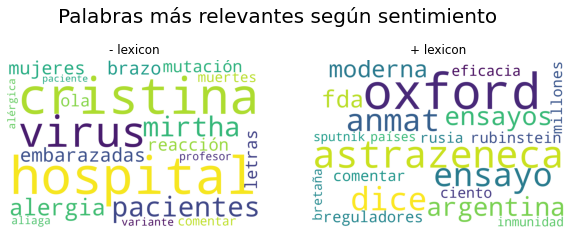

In [55]:
mes = 'Dic' #Cambiar al mes que se quiera observar
plotWC(df[df['mes']==mes], 'Texto')

Lo mismo pero por diario

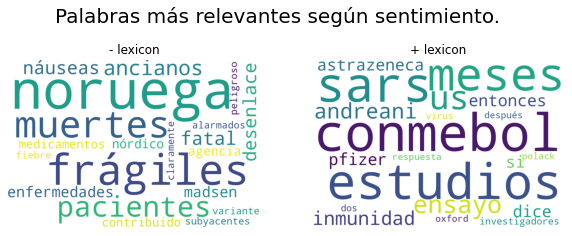

In [61]:
diario = 'LaNacion' #Cambiar al diario que se quiera observar
plotWC(df[df['Diario']==diario], 'Texto')

Quiero ver evolucion por mes del sentimiento y por diario

In [81]:
sent = df.groupby(['Diario','mes']).mean()
sent.reset_index(inplace=True)

In [87]:
#Esto resulta necesario para que me den los meses en orden
sent['mes'] = pd.Categorical(sent['mes'],
                                   categories=['Dic','Ene','Feb','Mar','Abr','May','Jun'],
                                   ordered=True)
    

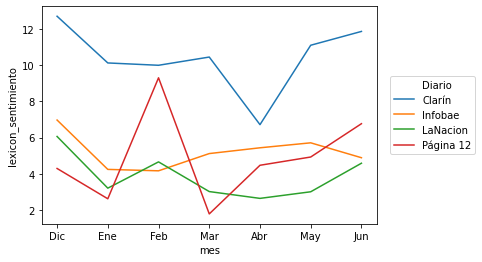

In [91]:
sbn.lineplot(x=sent['mes'], y= sent['lexicon_sentimiento'], hue=sent['Diario'])
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

Para alguna Vacuna particular

Text(0.5, 1.0, 'Pfizer')

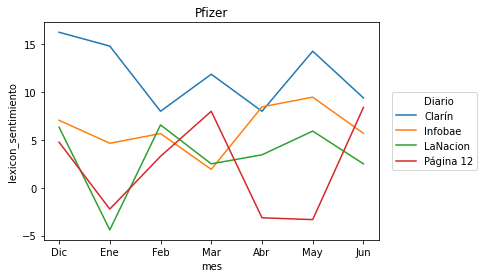

In [93]:
Vac = 'Pfizer'
df1 = df[df[Vac]==1]
sent = df1.groupby(['Diario','mes']).mean()
sent.reset_index(inplace=True)
sent['mes'] = pd.Categorical(sent['mes'],
                                   categories=['Dic','Ene','Feb','Mar','Abr','May','Jun'],
                                   ordered=True)
    
sbn.lineplot(x=sent['mes'], y= sent['lexicon_sentimiento'], hue=sent['Diario'])
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.title(str(Vac))

Esto puede repetirse con una escala comun. Queremos que nuestra metrica sea interpretable. Por eso reescaleamos los datos de sentimiento entre $[0,1]$ para mayor interpretabilidad. 0 es el mas negativo de la muestra y 1 el mas positivo. Esto se hace viendo cual es el menor y mayor score de sentimiento primero y haciendo la division que se ve en la celda de abajo. Naturalmente la utilidad de este escaleo depende de que se quiera estudiar. Si se quiere estudiar especificamente un diario en especifico puede verse en las tablas de arriba que sus minimos y maximos son muy distintos. Por lo que seria mas razonable en otros casos, normalizar las cosas por separado.

In [97]:
df['sentimiento_total'] = (df['lexicon_sentimiento'] - df['lexicon_sentimiento'].min()) / (df['lexicon_sentimiento'].max() - df['lexicon_sentimiento'].min())

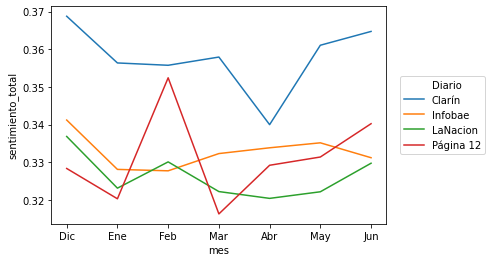

In [98]:
sent = df.groupby(['Diario','mes']).mean()
sent.reset_index(inplace=True)
sent['mes'] = pd.Categorical(sent['mes'],
                                   categories=['Dic','Ene','Feb','Mar','Abr','May','Jun'],
                                   ordered=True)
    
sbn.lineplot(x=sent['mes'], y= sent['sentimiento_total'], hue=sent['Diario'])
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

Text(0.5, 1.0, 'Pfizer')

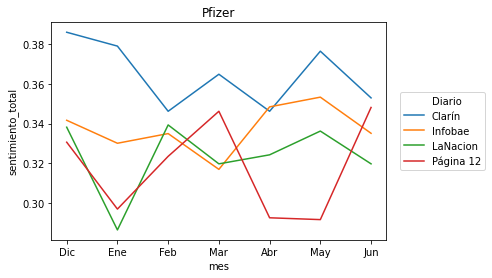

In [99]:
Vac = 'Pfizer'
df1 = df[df[Vac]==1]
sent = df1.groupby(['Diario','mes']).mean()
sent.reset_index(inplace=True)
sent['mes'] = pd.Categorical(sent['mes'],
                                   categories=['Dic','Ene','Feb','Mar','Abr','May','Jun'],
                                   ordered=True)
    
sbn.lineplot(x=sent['mes'], y= sent['sentimiento_total'], hue=sent['Diario'])
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.title(str(Vac))

Las formas son iguales a los graficos de arriba

Tambien podemos notar que los tamaños muestrales son muy distintos por lo que queremos probar para muestras de igual tamaño.

In [102]:
df_clarin = df[df['Diario']=='Clarín'].sample(588) 
df_infobae = df[df['Diario']=='Infobae'].sample(588)
df_ln = df[df['Diario']=='LaNacion'].sample(588)
df_p12 = df[df['Diario']=='Página 12']

df_norm = pd.concat([df_clarin, df_infobae, df_ln, df_p12])

In [103]:
df_norm.Diario.value_counts()

Página 12    588
LaNacion     588
Clarín       588
Infobae      588
Name: Diario, dtype: int64

In [104]:
df_norm['sentimiento_total'] = (df_norm['lexicon_sentimiento'] - df_norm['lexicon_sentimiento'].min()) / (df_norm['lexicon_sentimiento'].max() - df_norm['lexicon_sentimiento'].min())

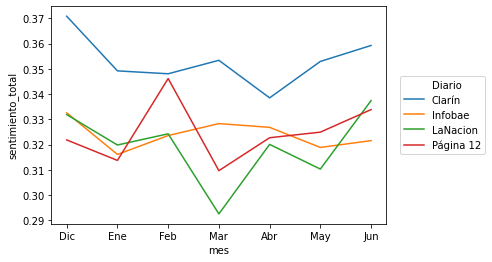

In [105]:
sent = df_norm.groupby(['Diario','mes']).mean()
sent.reset_index(inplace=True)
sent['mes'] = pd.Categorical(sent['mes'],
                                   categories=['Dic','Ene','Feb','Mar','Abr','May','Jun'],
                                   ordered=True)
    
sbn.lineplot(x=sent['mes'], y= sent['sentimiento_total'], hue=sent['Diario'])
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

Text(0.5, 1.0, 'Pfizer')

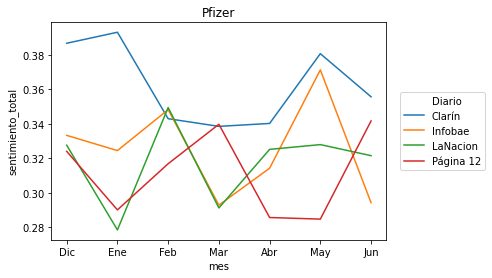

In [107]:
Vac = 'Pfizer'
df1 = df_norm[df_norm[Vac]==1]
sent = df1.groupby(['Diario','mes']).mean()
sent.reset_index(inplace=True)
sent['mes'] = pd.Categorical(sent['mes'],
                                   categories=['Dic','Ene','Feb','Mar','Abr','May','Jun'],
                                   ordered=True)
    
sbn.lineplot(x=sent['mes'], y= sent['sentimiento_total'], hue=sent['Diario'])
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.title(str(Vac))

La tendencia general se mantiene, pero hay distancias relativas entre puntos que cambiaron notablemente al achicar la muestra. Lo que es esperable

## Pequeña disgresion: O por que hay que cuestionar nuestras herramientas

Quiero mostrar dos ejemplos que me encontre en la marcha de los analisis. Las dos son oraciones sacadas de un par de noticias del dataset

In [113]:
sentiment = SentiLeak()
sentiment.compute_sentiment('El Reino Unido, que accedió al menos a la primera dosis el 49 por ciento de los británicos, pasó de tener 1.248 fallecidos en un día a tener 33.')


{'per_sentence_sentiment': [{'position': 0,
   'text': 'El Reino Unido, que accedió al menos a la primera dosis el 49 por ciento de los británicos, pasó de tener 1.248 fallecidos en un día a tener 33.',
   'score': -2.0}],
 'global_sentiment': -2.0}

In [114]:
sentiment.compute_sentiment('No hace falta ser Albert Einstein para darse cuenta de que a Larreta no le interesó jerarquizar a los docentes.')

{'per_sentence_sentiment': [{'position': 0,
   'text': 'No hace falta ser Albert Einstein para darse cuenta de que a Larreta no le interesó jerarquizar a los docentes.',
   'score': -2.0}],
 'global_sentiment': -2.0}

El analisis por texto lo separa en Oraciones al mismo y computa un valor de Score de sentimiento. Este se basa en procedimientos semanticos, es decir registra un valor de sentimiento para palabras conocidas, y no interpreta por contexto. Aca ambas oraciones tienen score negativo. Pero un hablante del lenguaje podra notar que la primera es una oracion positiva y que la segunda es mucho mas negativa o agresiva que lo que se propone en el score. Naturalmente, los resultados obtenidos con el metodo semantico pueden no reflejar las complejidades del lenguaje natural. Pueden ensayarse resultados con otros metodos de analisis, basados en embeddings o por aprendizaje automatico a ver que resultados se obtienen.